# Estimation of correlation between (centroid offset, position-angle offset) and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Ahmad Al - Imtiaz, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the parameters (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"` , `"phi_light"`, `"phi_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (through our calculations using the Euclidean distance formula, or otherwise) to the values of light and mass centeroid offsets, and the position-angle offset, $\Delta\phi$. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the biweight midcorrelation ($r_{bicorr}$) between the centeroid (and the position-angle offsets) and the $\Sigma$ values. By sampling multiple times and calculating the biweight midcorrelations ($r_{bicorr}$) we get a population of $r_{bicorr}$ values and thus calculate its mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae for centroid offset


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Relevant formulae for position-angle offset

For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [16]:
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import yaml
from numpy.random import normal
from astropy.stats import biweight_midcorrelation
import coloripy as cp
import matplotlib as mpl
import paperfig as pf
import seaborn as sns

## List of the model names

In [17]:
lens_names = [
    "DESIJ0132-1600",
    "DESIJ0136-0008",
    "DESIJ0201-2739",
    "DESIJ0215-2909",
    "DESIJ0618+5018",
    # "DESIJ0923+1829",
    "DESIJ1018-0121",
    # "DESIJ1101-0602",
    "DESIJ1205+4110",
    "DESIJ1501+5208",
    "DESIJ1537+1443",
    "DESIJ1554+0443",
    "DESIJ1624+0129",
    "DESIJ1709+3154",
    "DESIJ2158+0257",
]

## Uncertainty propagation

In [18]:
# list for storing the Sigmas
Sigma_10_dset = []
Sigma_10fs_dset = []
Sigma_20_dset = []
Sigma_20fs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = (
    []
)  # uncertainty propagated standard deviation of the center offsets
dphis = []  # mean offsets between the light and mass position angle
sigma_dphis = (
    []
)  # uncertainty propagated standard deviation of the position angle offsets

for i in range(len(lens_names)):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue

    list_params = [
        "center_x_light",
        "center_x_mass",
        "center_y_light",
        "center_y_mass",
        "q_mass",
        "q_light",
        "phi_mass",
        "phi_light",
        "gamma_shear",
        "phi_shear",
        "Sigma_10",
        "Sigma_10_flux_selected",
        "Sigma_20",
        "Sigma_20_flux_selected",
    ]
    # parameters filtered by list params
    outputs = {k: data.get(k) for k in list_params}

    data_points.append(outputs)

    Sigma_10_dset.append(data.get("Sigma_10"))
    Sigma_10fs_dset.append(data.get("Sigma_10_flux_selected"))
    Sigma_20_dset.append(data.get("Sigma_20"))
    Sigma_20fs_dset.append(data.get("Sigma_20_flux_selected"))

    x_diff = abs(
        data_points[i]["center_x_light"][0] - data_points[i]["center_x_mass"][0]
    )
    y_diff = abs(
        data_points[i]["center_y_light"][0] - data_points[i]["center_y_mass"][0]
    )
    center_diff = (x_diff**2 + y_diff**2) ** 0.5
    center_diffs.append(center_diff)

    sigma_x_light = mean(
        [data_points[i]["center_x_light"][1], data_points[i]["center_x_light"][2]]
    )
    sigma_x_mass = mean(
        [data_points[i]["center_x_mass"][1], data_points[i]["center_x_mass"][2]]
    )
    sigma_y_light = mean(
        [data_points[i]["center_y_light"][1], data_points[i]["center_y_light"][2]]
    )
    sigma_y_mass = mean(
        [data_points[i]["center_y_mass"][1], data_points[i]["center_y_mass"][2]]
    )

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2) ** 0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2) ** 0.5

    sigma_center_diff = (
        ((x_diff / center_diff) ** 2) * sigma_x_diff**2
        + ((y_diff / center_diff) ** 2) * sigma_y_diff**2
    ) ** 0.5
    sigma_center_diffs.append(sigma_center_diff)

    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphi = dphi * (180/np.pi)  # radians-to-degrees conversion
    dphis.append(dphi)

    sigma_phi_mass = mean(
        [data_points[i]["phi_mass"][1], data_points[i]["phi_mass"][2]]
    )
    sigma_phi_light = mean(
        [data_points[i]["phi_light"][1], data_points[i]["phi_light"][2]]
    )

    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2) ** 0.5
    sigma_dphi = sigma_dphi * (180/np.pi)  # radians-to-degrees conversion
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]
    data_points[i]["center_diff"] = [center_diff, sigma_center_diff, sigma_center_diff]

## Sampling and biweight midcorrelation ($r_{bicorr}$) calculation

### Function definition

In [19]:
# Function for sampling and calculating the pearson correlation coefficients between two parameters


def sample2_and_calc_r(param1, param2, size):
    """
    Sample and calculate biweight_midcorrelation between param1 and the param2, and return
    a list of the form [r_median, r_lower, r_upper]

    :param param1: parameter for normal distribution sampling
    :param param2: parameter for normal distribution sampling
    :param size: population size of the pearson-r samples
    :return: list; [r_median, r_upper, r_lower]
    """

    samples_r = []

    for i in range(size):
        p1 = []
        p2 = []

        for j in range(len(lens_names)):
            p1.append(
                normal(
                    data_points[j][param1][0],
                    (data_points[j][param1][1] + data_points[j][param1][2]) * 0.5,
                )
            )
            if isinstance(data_points[j][param2], list):
                p2.append(
                    normal(
                        data_points[j][param2][0],
                        (data_points[j][param2][1] + data_points[j][param2][2]) * 0.5,
                    )
                )
            else:
                p2.append(data_points[j][param2])

        samples_r.append(biweight_midcorrelation(np.array(p1), np.array(p2)))

    samples_r_arr = np.array(samples_r)
    r_median = np.median(samples_r_arr).item()
    r_lower = np.percentile(samples_r_arr, 16.0).item()
    r_upper = np.percentile(samples_r_arr, 84.0).item()

    return [r_median, r_upper, r_lower]

### Biweight midcorrelation ($r_{bicorr}$) calculation

In [20]:
size = 1000  # population size

# centoid offset cases
r_centroid_off_Sigma_10 = sample2_and_calc_r("center_diff", "Sigma_10", size)
r_centroid_off_Sigma_10fs = sample2_and_calc_r(
    "center_diff", "Sigma_10_flux_selected", size
)
r_centroid_off_Sigma_20 = sample2_and_calc_r("center_diff", "Sigma_20", size)
r_centroid_off_Sigma_20fs = sample2_and_calc_r(
    "center_diff", "Sigma_20_flux_selected", size
)

# position angle offset cases
r_dphi_Sigma_10 = sample2_and_calc_r("dphi", "Sigma_10", size)
r_dphi_Sigma_10fs = sample2_and_calc_r("dphi", "Sigma_10_flux_selected", size)
r_dphi_Sigma_20 = sample2_and_calc_r("dphi", "Sigma_20", size)
r_dphi_Sigma_20fs = sample2_and_calc_r("dphi", "Sigma_20_flux_selected", size)

## Error-bar plot

### Set the figure layout and typography

In [21]:
pf.set_fontscale(2.0)

# for MNRAS
mpl.rcParams["ps.fonttype"] = 42

# to change tex to Times New Roman in mpl
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"
plt.rcParams["mathtext.fontset"] = "custom"


sns.set(style="ticks", context="paper", font="Times New Roman", font_scale=2.0)
# sns.set_context('talk')
sns.set_style(
    {
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 2.0,
    }
)
# sns.set_palette('Set2')

cmap = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.6,
    dark=0.8,
    reverse=False,
    as_cmap=True,
)
cmap2 = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.2,
    dark=1.0,
    reverse=False,
    as_cmap=True,
)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale="power", power=2.5)

### Function definition

In [22]:
# Function for scatter ploting with error bars


def errbar_plot(dset1, dset2, error, param, r, ax):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o", color="r", alpha=0.5, capsize=5)

    match param[0]:
        case "S_10":
            ax.set_xlabel(r"$\Sigma_{10}$ (arcsec$^\text{-2}$)")
        case "S_10fs":
            ax.set_xlabel(r"$\Sigma_{10, \rm flux\ selected}$ (arcsec$^\text{-2}$)")
        case "S_20":
            ax.set_xlabel(r"$\Sigma_{20}$ (arcsec$^\text{-2}$)")
        case "S_20fs":
            ax.set_xlabel(r"$\Sigma_{20, \rm flux\ selected}$ (arcsec$^\text{-2}$)")
    match param[1]:
        case "centroid_offset":
            ax.set_ylabel(r"centroid offset (arcsec)")
        case "position_angle_offset":
            ax.set_ylabel(r"position-angle offset, $\Delta\phi$ (deg.)")

    ax.tick_params(direction="in")
    ax.text(
        0.8,
        0.8,
        f"$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        # fontsize=14,
        color="b",
    )

### Centroid offset vs.  $\Sigma$ cases

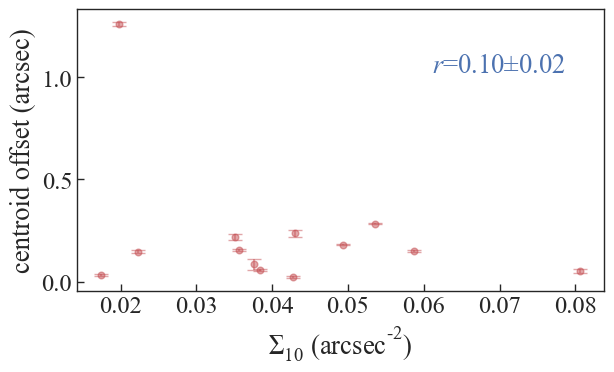

In [23]:
# plot for all the four cases of centroid offset vs. Sigmas


fig, ax = plt.subplots(1, 1, 
                       figsize=pf.get_fig_size(pf.mnras_colwidth * 2))

errbar_plot(
    Sigma_10_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10", "centroid_offset"],
    r_centroid_off_Sigma_10,
    ax,
)

fig.tight_layout()
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_10.pdf", bbox_inches="tight")

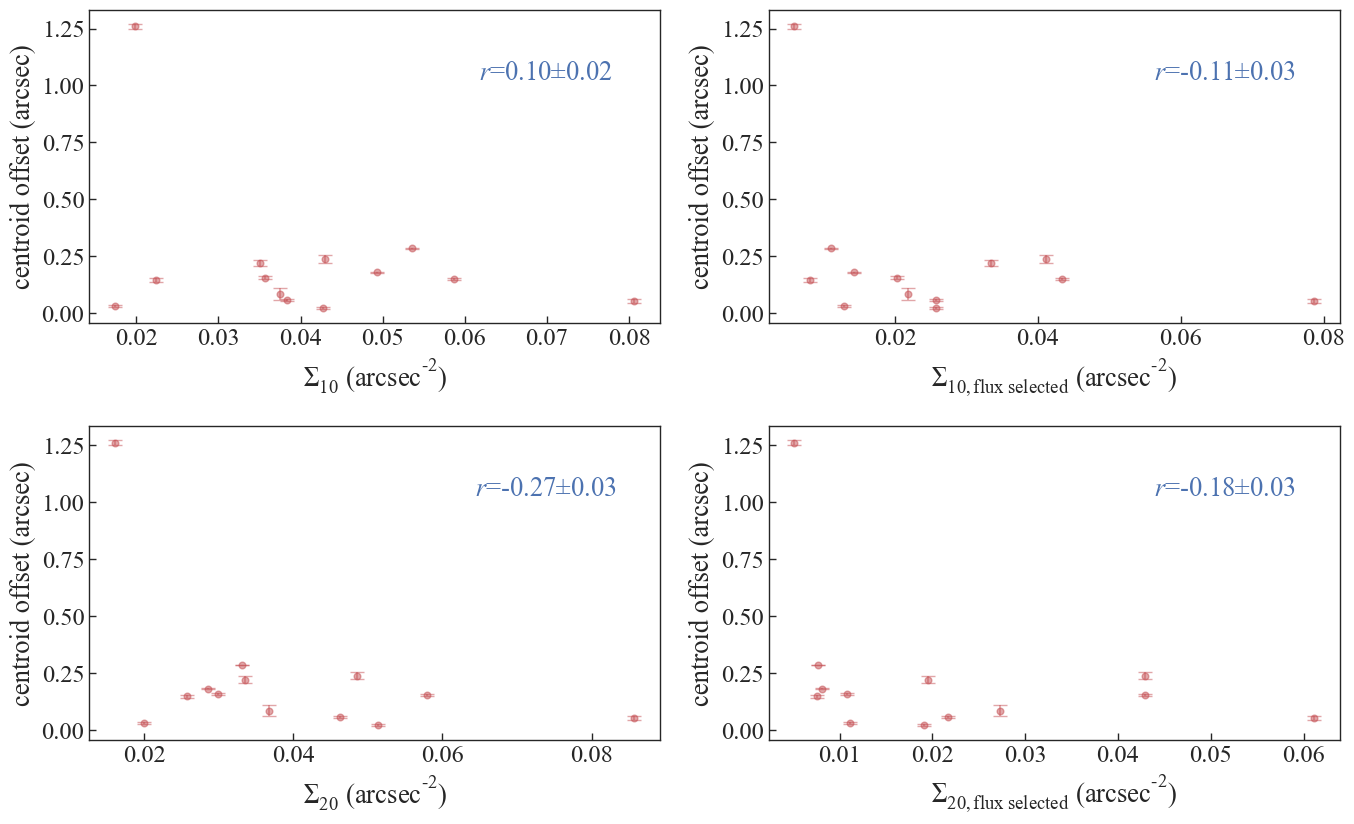

In [24]:
# plot for all the four cases of centroid offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10", "centroid_offset"],
    r_centroid_off_Sigma_10,
    ax1,
)
errbar_plot(
    Sigma_10fs_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_10fs", "centroid_offset"],
    r_centroid_off_Sigma_10fs,
    ax2,
)
errbar_plot(
    Sigma_20_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_20", "centroid_offset"],
    r_centroid_off_Sigma_20,
    ax3,
)
errbar_plot(
    Sigma_20fs_dset,
    center_diffs,
    sigma_center_diffs,
    ["S_20fs", "centroid_offset"],
    r_centroid_off_Sigma_20fs,
    ax4,
)

fig.tight_layout()
plt.show()
fig.savefig("../paper/figures/centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")

### Position-angle offset vs. $\Sigma$ cases

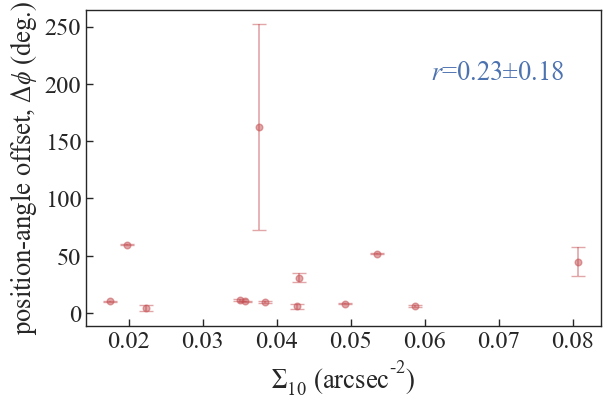

In [25]:
# plot for all the four cases of centroid offset vs. Sigmas

fig, ax = plt.subplots(1, 1, 
                       figsize=pf.get_fig_size(pf.mnras_colwidth * 2))

errbar_plot(
    Sigma_10_dset,
    dphis,
    sigma_dphis,
    ["S_10", "position_angle_offset"],
    r_dphi_Sigma_10,
    ax,
)

# fig.tight_layout()
plt.show()
fig.savefig(
    "../paper/figures/position_angle_offset_vs_Sigma_10.pdf", bbox_inches="tight"
)

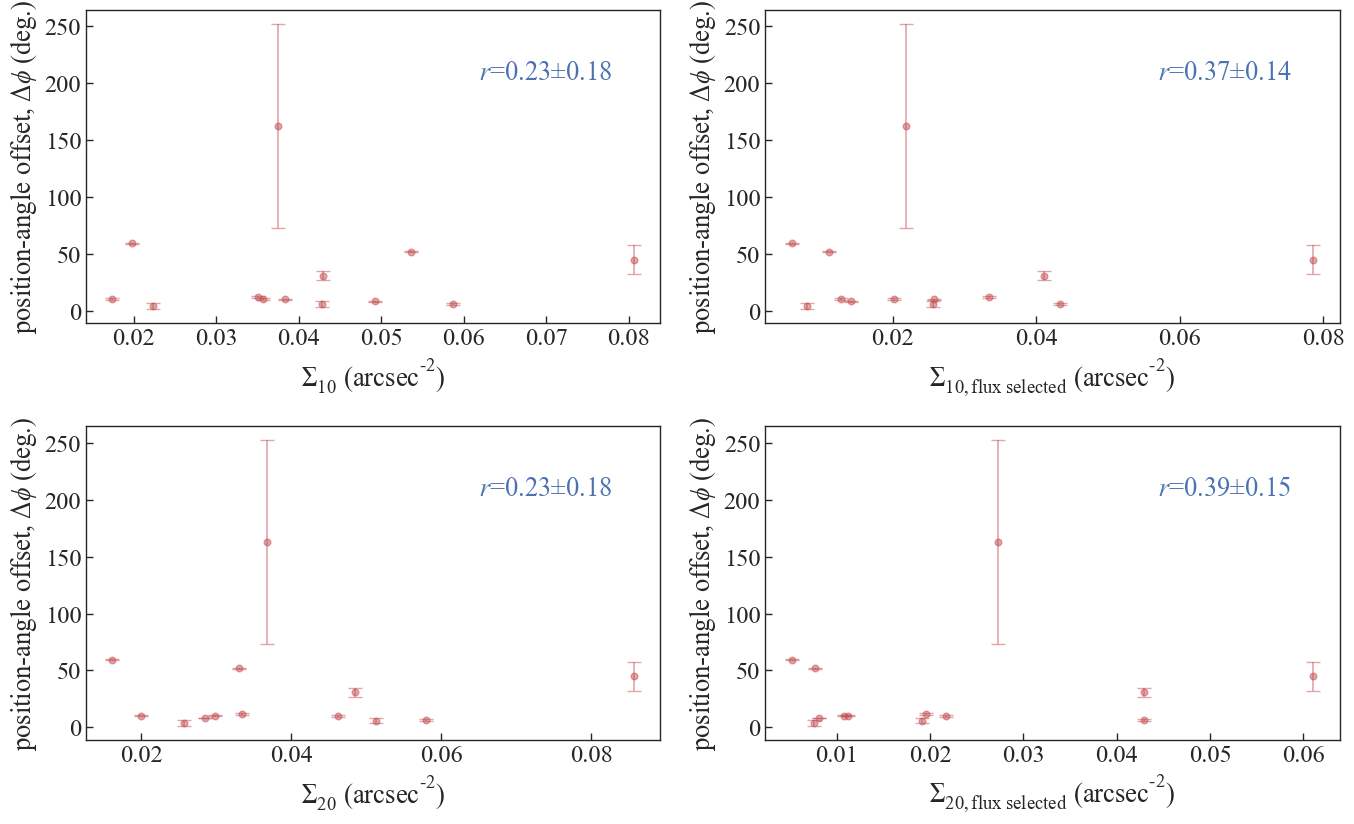

In [26]:
# plot for all the four cases of position angle offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=pf.get_fig_size(pf.mnras_textwidth * 2))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10_dset,
    dphis,
    sigma_dphis,
    ["S_10", "position_angle_offset"],
    r_dphi_Sigma_10,
    ax1,
)
errbar_plot(
    Sigma_10fs_dset,
    dphis,
    sigma_dphis,
    ["S_10fs", "position_angle_offset"],
    r_dphi_Sigma_10fs,
    ax2,
)
errbar_plot(
    Sigma_20_dset,
    dphis,
    sigma_dphis,
    ["S_20", "position_angle_offset"],
    r_dphi_Sigma_20,
    ax3,
)
errbar_plot(
    Sigma_20fs_dset,
    dphis,
    sigma_dphis,
    ["S_20fs", "position_angle_offset"],
    r_dphi_Sigma_20fs,
    ax4,
)

fig.tight_layout()
plt.show()
fig.savefig(
    "../paper/figures/position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight"
)